$
\newcommand{ket}[1]{\vert#1\rangle}
\newcommand{bra}[1]{\langle#1\vert}
\newcommand{\AA}{\unicode{x212B}}
$

# How is the energy (expectation value) calculated?

- [1. Introduction](#sec1)

- [2. Methodology](#sec2)
   - [2.1 Workflow](#sec21)
   - [2.2 Example: Pauli string $\hat{X} \otimes \hat{X}$](#sec22)
   - [2.3 Example: Pauli string $\hat{Y} \otimes \hat{X}$](#sec23)
   - [2.4 Example: Pauli string $\hat{I} \otimes \hat{Z}$](#sec24)

- [3. Computing the energy and comparing against built-in `Estimator()`](#sec3)


<a id='sec1'></a>
## 1. Introduction

Energy is the expectation value (braket) of the Hamiltonian operator: $ E = \bra{\Psi} \hat{h} \ket{\Psi}$ . In classical computers, this braket is computed explicitly. In a quantum computer, however, it follows a different methodology, from which it stems the computational advantage over classical computing: the braket is estimated from measurements performed on quantum circuits (a different circuit per Pauli string) by combining the probabilites resulting from the measurements, as will be shown.

Here, we present examples to illustrate the technicalities involved in this methodology. The two-qubit Hamiltonian $\hat{h}$ for $H_2$ (at bondlength $0.735 \AA$) is 
$  \hat{h} = 
         -1.0523732 \cdot \hat{I}\otimes \hat{I} 
        +0.39793742 \cdot \hat{I}\otimes \hat{Z} 
         -0.3979374 \cdot \hat{Z}\otimes \hat{I}
         -0.0112801 \cdot \hat{Z}\otimes \hat{Z}
        +0.18093119 \cdot \hat{X}\otimes \hat{X} 
$ 
; where $\ket{\Psi} = \ket{11}$ is the Hartree-Fock wavefunction. The expression for the energy is composed of 5 terms (one per Pauli strings).

$$  
\begin{align*}
E &= \bra{\Psi} \hat{h} \ket{\Psi} \\ 
  &=       -1.0523732 \bra{\Psi} \hat{I} \otimes \hat{I} \ket{\Psi} 
        +0.39793742 \bra{\Psi} \hat{I} \otimes \hat{Z} \ket{\Psi} 
         -0.3979374 \bra{\Psi} \hat{Z} \otimes \hat{I} \ket{\Psi}
         -0.0112801 \bra{\Psi} \hat{Z} \otimes \hat{Z} \ket{\Psi}
        +0.18093119 \bra{\Psi} \hat{X} \otimes \hat{X} \ket{\Psi} 
\end{align*}
$$ 

Each term is computed summing the probabilities, $P$, obtained from measuring quantum circuits. In this notebook, we'll demonstrate the following identities

$$
\begin{gather*}
\bra{\Psi} \hat{I} \otimes \hat{I} \ket{\Psi} = P_{\ket{\Psi'}}(\ket{00}) + P_{\ket{\Psi'}}(\ket{01}) + P_{\ket{\Psi'}}(\ket{10}) + P_{\ket{\Psi'}}(\ket{11}) \\ 
\bra{\Psi} \hat{I} \otimes \hat{Z} \ket{\Psi} = P_{\ket{\Psi'}}(\ket{00}) - P_{\ket{\Psi'}}(\ket{01}) + P_{\ket{\Psi'}}(\ket{10}) - P_{\ket{\Psi'}}(\ket{11}) \\ 
\bra{\Psi} \hat{Z} \otimes \hat{I} \ket{\Psi} = P_{\ket{\Psi'}}(\ket{00}) + P_{\ket{\Psi'}}(\ket{01}) - P_{\ket{\Psi'}}(\ket{10}) - P_{\ket{\Psi'}}(\ket{11}) \\ 
\bra{\Psi} \hat{Z} \otimes \hat{Z} \ket{\Psi} = P_{\ket{\Psi'}}(\ket{00}) - P_{\ket{\Psi'}}(\ket{01}) - P_{\ket{\Psi'}}(\ket{10}) + P_{\ket{\Psi'}}(\ket{11}) \\ 
\bra{\Psi} \hat{X} \otimes \hat{X} \ket{\Psi} = P_{\ket{\Psi'}}(\ket{00}) - P_{\ket{\Psi'}}(\ket{01}) - P_{\ket{\Psi'}}(\ket{10}) + P_{\ket{\Psi'}}(\ket{11}) \\ 
\end{gather*}
$$

and use Qiskit to *manually* compute the energy. Finally, we'll compare against the results obtained using Qiskit's built-in class `Estimator()`. 
$\ket{\Psi'}$ (different from $\ket{\Psi}$) are outputs of extended circuits (explained below). Here the notation will follow Qiskit ordering, e.g. the operator $\hat{Z} \otimes \hat{I}$ applies $\hat{I}$ to the least-significant bit LSB (right most) and $\hat{Z}$ to the most-significant bit (left most). 



<a id='sec2'></a>
## 2. Methodology

<a id='sec21'></a>
### 2.1 Workflow

- A. We create an initial quantum circuit that builds the wavefunction (aka ansatz). For the simple $\Psi = \ket{11}$, the circuit has one layer with  one $X$ gate on each line.

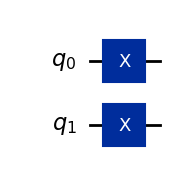

In [1]:
import numpy
from qiskit.circuit import QuantumCircuit
from qiskit.quantum_info import SparsePauliOp

# Two-qubit Hamitonian operator for H2 @ 0.735 Ang bond length
H2_operators = [ 
        [SparsePauliOp(["II"], [ -1.0523732])],
        [SparsePauliOp(["IZ"], [ 0.39793742])],
        [SparsePauliOp(["ZI"], [ -0.3979374])], #I to q0 (LSB), Z to q1 (MSB)
        [SparsePauliOp(["ZZ"], [ -0.0112801])],
        [SparsePauliOp(["XX"], [ 0.18093119])],
]

# Defining the wavefunction as the HF state |11>.
psi_HF = QuantumCircuit(2)
psi_HF.x(0) 
psi_HF.x(1)
psi_HF.draw("mpl")

- B. The energy of each Pauli string is computed independently and added. For each Pauli string we create an extended circuit, which appends gates to each qubit line according to the observable for that line:
    - For observable $\hat{X}$, append a Hadamard gate $H$. 
    - For observable $\hat{Y}$, append an $S^\dagger$ gate then a $H$ gate. 
    - For observables $\hat{Z}$ or $\hat{I}$, do nothing.
    
- C. Add measurements to each line and run the circuit. Measuring $\ket{\Psi'}$ (the output of extended circuit; measured at the second barrier, after the H gates in the figure below) yields the probabilities for each possible basis state in $\ket{\Psi'}$. Use these probabilities, e.g. $P_{\Psi'}(\ket{01})$, to compute the expectation value for the Pauli string.

- D. Finally, the energy $H_2$ is obtained by adding the expectation values of each Pauli string, weighted by the corresponding coefficients seen in the expansion of $\hat{h}$. 

<a id='sec22'></a>
### 2.2 Example: Pauli string $\hat{X} \otimes \hat{X}$


The extended circuit for the Pauli string $\hat{X} \otimes \hat{X}$ adds Hadamard gates, as shown below, and the expectation value can be calculated as
$$
\bra{\Psi} \hat{X} \otimes \hat{X} \ket{\Psi} = \bra{\Psi'} \hat{Z} \otimes \hat{Z} \ket{\Psi'} = P_{\ket{\Psi'}}(\ket{00}) - P_{\ket{\Psi'}}(\ket{01}) - P_{\ket{\Psi'}}(\ket{10}) + P_{\ket{\Psi'}}(\ket{11}) \\ 
$$
where $\Psi$ is the molecular wavefunction, measure at the first barrier, after the X gates.

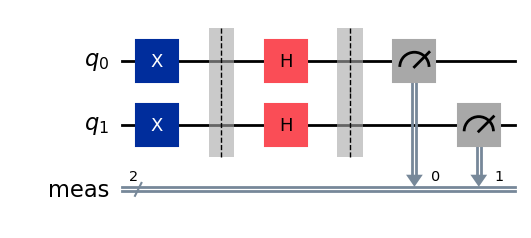

In [2]:
circ = psi_HF.copy(); circ.barrier(); circ.h(0); circ.h(1); circ.measure_all(); circ.draw("mpl")

#### Demonstrate: $\bra{\Psi} \hat{X} \otimes \hat{X} \ket{\Psi} = \bra{\Psi'} \hat{Z} \otimes \hat{Z} \ket{\Psi'}$

From the extended circuit, we have $\ket{\Psi'} = (\hat{H}_1 \otimes \hat{H}_0) \ket{\Psi}$. Also, we'll use the known identity $\hat{X} = \hat{H} \otimes \hat{Z} \otimes \hat{H}$.
$$
\begin{align*}
 \bra{\Psi'} \hat{Z}_1 \otimes \hat{Z}_0 \ket{\Psi'} 
 &= \bra{\Psi} (\hat{H}_1 \otimes \hat{H}_0) (\hat{Z}_1 \otimes \hat{Z}_0) (\hat{H}_1 \otimes \hat{H}_0)\ket{\Psi} \\
 &= \bra{\Psi} (\hat{H}_1 \otimes \hat{Z}_1 \otimes \hat{H}_1) \otimes (\hat{H}_0 \otimes \hat{Z}_0 \otimes \hat{H}_0) \ket{\Psi} \\
 &= \bra{\Psi} \hat{X}_1 \otimes \hat{X}_0 \ket{\Psi} \\
\end{align*}
$$

#### Evaluate: $\bra{\Psi'} \hat{Z} \otimes \hat{Z} \ket{\Psi'}$
$$
\begin{align*}
\bra{\Psi'} \hat{Z}_1 \otimes \hat{Z}_0 \ket{\Psi'} 
&= \bra{\Psi'} (\ket{0}_1\bra{0}_1 - \ket{1}_1\bra{1}_1 ) \otimes (\ket{0}_0\bra{0}_0 - \ket{1}_0\bra{1}_0 ) \ket{\Psi'} \\
&= \bra{\Psi'} (
                \ket{0}_1\bra{0}_1 \otimes \ket{0}_0\bra{0}_0 
               -\ket{0}_1\bra{0}_1 \otimes \ket{1}_0\bra{1}_0
               -\ket{1}_1\bra{1}_1 \otimes \ket{0}_0\bra{0}_0 
               +\ket{1}_1\bra{1}_1 \otimes \ket{1}_0\bra{1}_0 
) \ket{\Psi'} \\

&= \bra{\Psi'} (
                [\ket{0}_1 \otimes \ket{0}_0] [\bra{0}_1 \otimes \bra{0}_0] 
               -[\ket{0}_1 \otimes \ket{1}_0] [\bra{0}_1 \otimes \bra{1}_0]
               -[\ket{1}_1 \otimes \ket{0}_0] [\bra{1}_1 \otimes \bra{0}_0] 
               +[\ket{1}_1 \otimes \ket{1}_0] [\bra{1}_1 \otimes \bra{1}_0] 
) \ket{\Psi'} \\
&= \bra{\Psi'} (
                \ket{00} \bra{00}  
               -\ket{01} \bra{01} 
               -\ket{10} \bra{10}  
               +\ket{11} \bra{11}  
) \ket{\Psi'} \\
&=  
     |\bra{00} \Psi'\rangle |^2 
    -|\bra{01} \Psi'\rangle |^2
    -|\bra{10} \Psi'\rangle |^2 
    +|\bra{11} \Psi'\rangle |^2 
     \\
&=  
     P_{\ket{\Psi'}}(\ket{00})
    -P_{\ket{\Psi'}}(\ket{01})
    -P_{\ket{\Psi'}}(\ket{10})
    +P_{\ket{\Psi'}}(\ket{11})
     \\
\end{align*}
$$

<a id='sec23'></a>
### 2.3 Example: Pauli string $\hat{Y} \otimes \hat{X}$

The extended circuit for the Pauli string $\hat{Y} \otimes \hat{X}$ adds Hadamard gates, as shown below, and the expectation value can be calculated as
$$
\bra{\Psi} \hat{Y} \otimes \hat{X} \ket{\Psi} = \bra{\Psi''} \hat{Z} \otimes \hat{Z} \ket{\Psi''} = P_{\Psi''}(\ket{00}) - P_{\Psi''}(\ket{01}) - P_{\Psi''}(\ket{10}) + P_{\Psi''}(\ket{11}) \\ 
$$
where $\ket{\Psi''}$ is different from $\ket{\Psi'}$ because they are outputs of two different extended circuits.

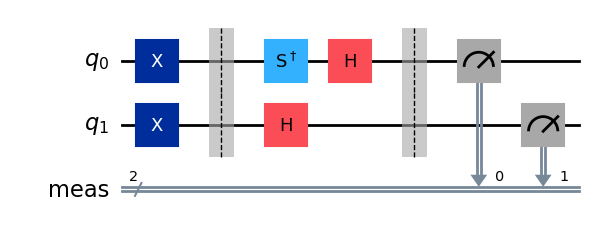

In [3]:
circ = psi_HF.copy(); circ.barrier(); circ.sdg(0); circ.h(0); circ.h(1); circ.measure_all(); circ.draw("mpl")

<a id='sec24'></a>
### 2.4 Example: Pauli string $\hat{I} \otimes \hat{Z}$

For most Pauli strings, like the two examples above, the expectation values can be calculated using the same pattern (signs) in adding the probabilities. 

However, it will differ for cases where the string contains at least one $I$ operator. For case $\hat{I}\hat{Z}$, the extended circuit is the same as the original circuit and the expectation value is

$$
\begin{align*}
\bra{\Psi} \hat{I} \otimes \hat{Z} \ket{\Psi} &= \bra{\Psi}(\ket{0}_1\bra{0}_1 + \ket{1}_1\bra{1}_1) \otimes (\ket{0}_0\bra{0}_0 - \ket{1}_0\bra{1}_0) \ket{\Psi} \\

&= \bra{\Psi} (
                [\ket{0}_1 \otimes \ket{0}_0] [\bra{0}_1 \otimes \bra{0}_0] 
               -[\ket{0}_1 \otimes \ket{1}_0] [\bra{0}_1 \otimes \bra{1}_0]
               +[\ket{1}_1 \otimes \ket{0}_0] [\bra{1}_1 \otimes \bra{0}_0] 
               -[\ket{1}_1 \otimes \ket{1}_0] [\bra{1}_1 \otimes \bra{1}_0] 
) \ket{\Psi} \\

&= \bra{\Psi} (
                \ket{00} \bra{00}  
               -\ket{01} \bra{01} 
               +\ket{10} \bra{10}  
               -\ket{11} \bra{11}  
) \ket{\Psi} \\
&=  
     |\bra{00} \Psi'\rangle |^2 
    -|\bra{01} \Psi'\rangle |^2
    +|\bra{10} \Psi'\rangle |^2 
    -|\bra{11} \Psi'\rangle |^2 
     \\
&=  
     P_{\ket{\Psi'}}(\ket{00})
    -P_{\ket{\Psi'}}(\ket{01})
    +P_{\ket{\Psi'}}(\ket{10})
    -P_{\ket{\Psi'}}(\ket{11})
     \\

\end {align*}
$$


<a id='sec3'></a>
## 3. Computing the energy and comparing against built-in `Estimator()`

Pauli string =  II , weight= -1.0523732
Energy= -1.0523732 Ha [ -1.0523732 from Estimator() ]

-------------------

Pauli string =  IZ , weight= 0.39793742
Energy= -0.39793742 Ha [ -0.39793742 from Estimator() ]

-------------------

Pauli string =  ZI , weight= -0.3979374
Energy= 0.3979374 Ha [ 0.3979374 from Estimator() ]

-------------------

Pauli string =  ZZ , weight= -0.0112801
Energy= -0.0112801 Ha [ -0.0112801 from Estimator() ]

-------------------

Pauli string =  XX , weight= 0.18093119


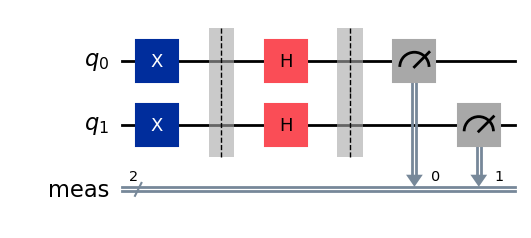

Energy= -0.003510065086 Ha [ 0.0 from Estimator() ]

-------------------



H2 electronic energy =  -1.0671633850859998 Ha [ -1.0636533199999998 from Estimator() ]


In [4]:
from qiskit.primitives import BitArray
from qiskit_aer.primitives import SamplerV2, EstimatorV2

def getSumOfProbabilities(qubit_string : str, measurement : BitArray) -> dict:
    states_with_counts = measurement.get_counts()
    nshots = measurement.num_shots
  
    table_of_coeffs_for_sum = {
    "II": {'00': 1.0, '01': 1.0, '10': 1.0, '11': 1.0},
    "IZ": {'00': 1.0, '01':-1.0, '10': 1.0, '11':-1.0},
    "ZI": {'00': 1.0, '01': 1.0, '10':-1.0, '11':-1.0},
    "ZZ": {'00': 1.0, '01':-1.0, '10':-1.0, '11': 1.0},
    }
    string = qubit_string if ("I" in qubit_string) else "ZZ" #in the extended circuit, all other cases (such as "XY") follow as "ZZ"
    prob = 0.0
    for state, coeff in table_of_coeffs_for_sum[string].items():
        prob += coeff * states_with_counts[state]/nshots if state in states_with_counts.keys() else 0.0
    return prob 

Pauli_string_list = [
    ["II",  -1.0523732],
    ["IZ",  0.39793742],
    ["ZI",  -0.3979374], #I to q0 (LSB), Z to q1 (MSB)
    ["ZZ",  -0.0112801],
    ["XX",  0.18093119]
]

nshots = 10000

# Calculate the energy using built-in class Estimator() 
pub = (psi_HF, H2_operators)
estimator = EstimatorV2() 
results = estimator.run([pub]).result()[0] 
estimations = results.data.evs
#print("H2 electronic energy", numpy.sum(estimations))
#print("contribution of each Pauli string:\n", estimations)

# Calculate the energy manually 
psi = psi_HF.copy()
energy_list = []

for i, (Pauli_string, weight) in enumerate(Pauli_string_list):
    print("Pauli string = ", Pauli_string, ", weight=", weight)
    #1. Create a extended circuit for each Pauli-string operator. This append the gates 'needed' for obtaining expectation values
    circ = psi.copy()
    circ.barrier()
    for i_qubit, i_operator in enumerate(Pauli_string[::-1]):
        if i_operator == "X": 
            circ.h(i_qubit)
        if i_operator == "Y": 
            circ.sdg(i_qubit) #S^{\dag}
            circ.h(i_qubit)
    circ.measure_all()
    if Pauli_string in ["XX"]: display(circ.draw("mpl"))

    #2. Perform measurements of the extended circuits
    sampler = SamplerV2()
    job = sampler.run([circ], shots=nshots)
    result_ideal = job.result()
    data = result_ideal[0].data
    measurements = data.meas
    energy = weight * getSumOfProbabilities(Pauli_string, measurements)
    #print(Pauli_string, "weight=", weight, "energy=", energy)
    energy_list.append(energy)
    print("Energy=", energy, "Ha", "[", estimations[i][0], "from Estimator() ]")
    print("\n-------------------\n")
print("\n\nH2 electronic energy = ", numpy.array(energy_list).sum(), "Ha", "[", numpy.sum(estimations), "from Estimator() ]")


In [5]:
!pip list | grep "notebook"
!pip list | grep "qiskit"
!python --version

notebook                          7.2.2
notebook_shim                     0.2.4
qiskit                            1.2.4
qiskit-aer                        0.15.1
qiskit-algorithms                 0.3.1
qiskit-ibm-provider               0.11.0
qiskit-ibm-runtime                0.31.0
qiskit-nature                     0.7.2
Python 3.13.0
